
# Assignment-#02
### Stereo Depth Estimation Using SIFT. Complete each question by implementing the required functions and code cells, following the instructions provided.



### Import Libraries


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Define Camera Parameters

In [ ]:
focal_length = 4152.073
baseline =  176.252

### Load Stereo Images

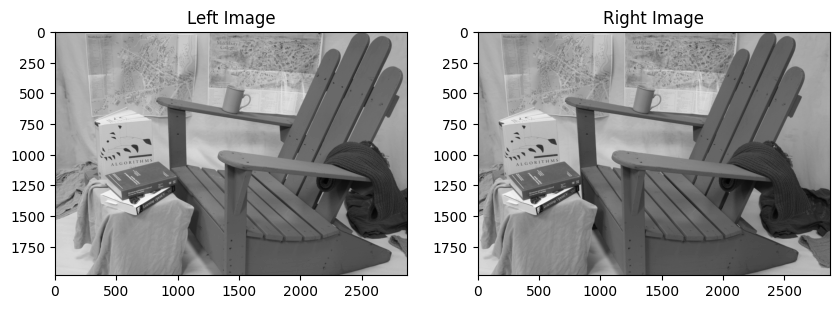

In [ ]:

left_image = cv2.imread('./Images/im0.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('./Images/im1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise ValueError("Images not found! Make sure 'left_image.jpg' and 'right_image.jpg' are in the same directory.")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(left_image, cmap='gray'), plt.title("Left Image")
plt.subplot(1, 2, 2), plt.imshow(right_image, cmap='gray'), plt.title("Right Image")
plt.show()

### Q1. Describe the differences you observe in the left and right images (2 Points) 

In these two images, the objects appear slightly shifted between the left and right views. For example, the chair and books look like they’ve moved a little to the left in the right image compared to the left image. This shift is more noticeable in closer objects, like the chair, while things in the background don’t shift as much. This difference between the two images helps create a sense of depth, allowing us to tell how far away objects are.

### Q2. Write a function to detects and matches SIFT features between two images using FLANN-based matcher and Lowe's ratio test. (3 Points).

In [ ]:
def detect_and_match_features(left_image, right_image, ratio_test_threshold=0.85):
    sift = cv2.SIFT_create(
        # nfeatures=100000,
        nOctaveLayers=20,
        contrastThreshold=0.0001,
        edgeThreshold=0.01,
        sigma=1.2 
    )
    
    keypoints_left, descriptors_left = sift.detectAndCompute(left_image, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(right_image, None)

    index_params = dict(algorithm=1, trees=1)
    search_params = dict(checks=200)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_test_threshold * n.distance]

    matched_image = cv2.drawMatches(left_image, keypoints_left, right_image, keypoints_right, good_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    for match in good_matches:
        pt_left = tuple(map(int, keypoints_left[match.queryIdx].pt))
        pt_right = tuple(map(int, keypoints_right[match.trainIdx].pt))
        
        cv2.circle(matched_image, pt_left, 5, (0, 255, 0), thickness=2)
        cv2.circle(matched_image, (pt_right[0] + left_image.shape[1], pt_right[1]), 5, (0, 255, 0), thickness=2)

    return good_matches, keypoints_left, keypoints_right, matched_image


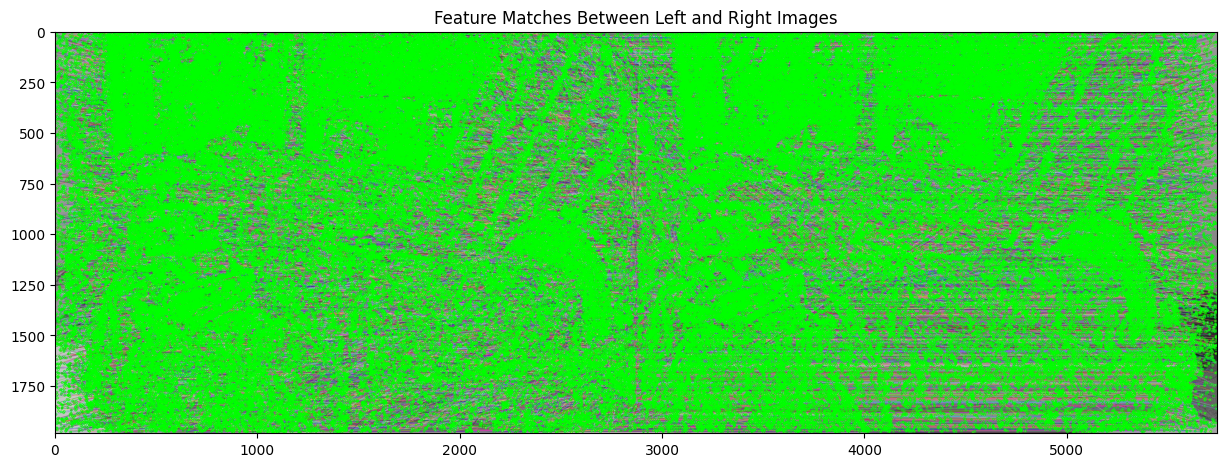

In [ ]:
good_matches, keypoints_left, keypoints_right, matched_image = detect_and_match_features(left_image, right_image)
plt.figure(figsize=(15, 10))
plt.imshow(matched_image)
plt.title("Feature Matches Between Left and Right Images")
plt.show()


### Q3. Write a function to calculates the disparity between matched keypoints in left and right images. (3 Points).

In [ ]:
def calculate_disparity(keypoints_left, keypoints_right, good_matches, doffs=0.8):
    
    disparities = []
    xl_coords = []
    xr_coords = []
    yl_coords = []
    for match in good_matches:
        xL = int(keypoints_left[match.queryIdx].pt[0])
        yL = int(keypoints_left[match.queryIdx].pt[1])
        xR = int(keypoints_right[match.trainIdx].pt[0])
        disparities.append((xL - xR) + doffs)
        xl_coords.append(xL)
        xr_coords.append(xR)
        yl_coords.append(yL)

    return disparities, xl_coords, xr_coords, yl_coords


In [17]:
def calculate_disparity_map(disparities, xl_coords, xr_coords,yl_coords,image_shape,point_size=3):

    disparity_map = np.zeros(image_shape, dtype=np.float32)
    for disparity , xL , xR , yL in zip(disparities, xl_coords, xr_coords ,yl_coords):
        for dx in range(-point_size, point_size + 1):
            for dy in range(-point_size, point_size + 1):
                if 0 <= xL + dx < image_shape[1] and 0 <= yL + dy < image_shape[0]:
                    disparity_map[yL + dy, xL + dx] = disparity
                    
    return disparity_map                

 ### Display the disparity map

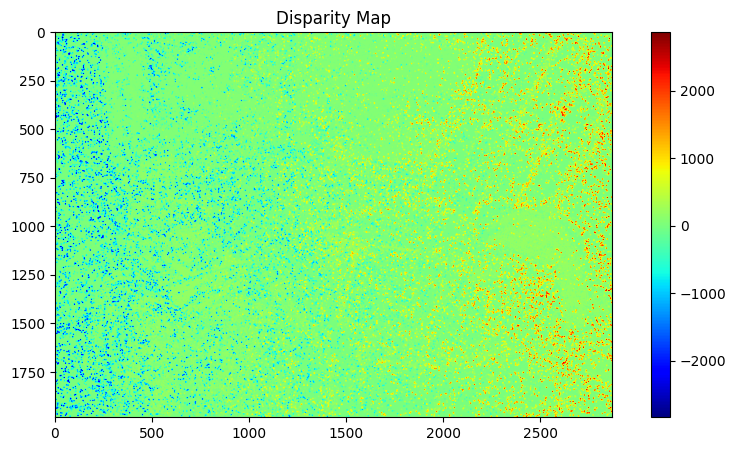

In [18]:

disparities, xl_coords, xr_coords, yl_coords = calculate_disparity(keypoints_left, keypoints_right, good_matches)
disparity_map = calculate_disparity_map(disparities, xl_coords, xr_coords, yl_coords,left_image.shape,3)
plt.figure(figsize=(10, 5))
plt.imshow(disparity_map, cmap='jet')
plt.colorbar()
plt.title("Disparity Map")
plt.show()



### Q4.  Write  a  function  to  calculates  the  depth  map  from  a  given  disparity  map,  focal length, and baseline  (3 Points). 

In [19]:
def calculate_depth_map(disparity_map, focal_length, baseline):
    disparity_map[disparity_map <= 0] = 0.1
    depth_map = (focal_length * baseline) / disparity_map
    return depth_map


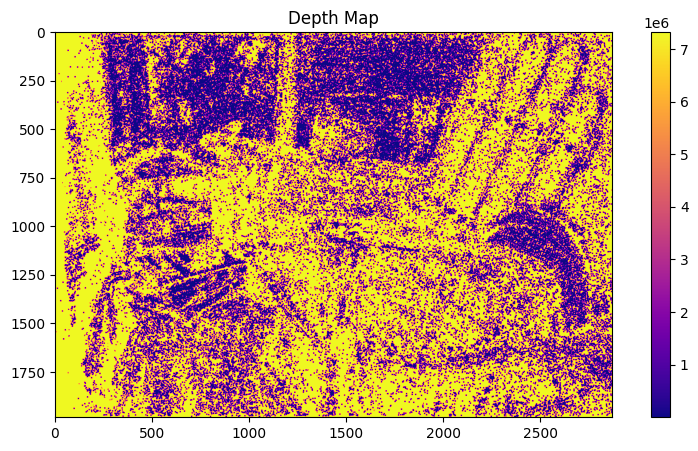

In [ ]:
focal_length = 4152.073
baseline = 176.252

depth_map = calculate_depth_map(disparity_map, focal_length, baseline)

plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title("Depth Map")
plt.show()


### Q5. Disparity Map Analysis:  What does the disparity map represent, and how does it relate to depth perception? Provide the mathematical relationship (2 Points). 

The disparity map shows the horizontal shift of corresponding points between the left and right images of a stereo pair. This shift, or disparity, helps in determining the depth of objects in the scene: closer objects have a larger disparity, while farther objects have a smaller disparity. Thus, disparity and depth are inversely related—when disparity increases, depth decreases, and vice versa. The mathematical relationship for depth can be described as:

Depth (distance to object) = (Baseline distance between cameras * Focal length of the camera) / Disparity (horizontal shift between images)
